In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import pandas as pd
from pupil_src.shared_modules import file_methods
import pprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import csv
import json
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import entropy

mpl.rcParams['figure.dpi'] = 144
mpl.rcParams['figure.figsize'] = (8, 5)

pp = pprint.PrettyPrinter(indent=4)

In [1]:
SUBJECTS = [
    {
        'ssid': "LR",
        'ppid': '00',
        'session_data': 'session_data_1556501517'
    },
    {
        'ssid': "MC",
        'ppid': '01',       
        'session_data': 'session_data_1556561644'
    },
    {
        'ssid': "CH",
        'ppid': '02',    
        'session_data': 'session_data_1556567724'
    },
    {
        'ssid': "NH",
        'ppid': '03',        
        'session_data': 'session_data_1556654588'
    },
    {
        'ssid': "JC",
        'ppid': '04',        
        'session_data': 'session_data_1556666097'
    },
    {
        'ssid': "JG",
        'ppid': '05',
        'session_data': 'session_data_1557423411'
    }
]
N = len(SUBJECTS)

In [9]:
def load_json(file):
    data = None
    with open(file) as f:
        data = json.load(f)
    return data

def get_session_info(ppid):
    systime, synctime = None, None
    with open('../TrialData/PupilRecordings/%s/info.csv' % ppid, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[0] == "Start Time (System)":
                systime = float(row[1])
            elif row[0] == "Start Time (Synced)":
                synctime = float(row[1])
    return (systime, synctime)

def df_to_tuples(df):
    return [tuple(x) for x in df.values]    

def generate_trial_df(session_data, towers, roll_median=None, ppid=None):
    trial_df = pd.DataFrame(columns=[
        'ppid', 'trial', 'tower', 'response', 'correct', 'falls',
        'gazepoints', 'mean_roll', 'pct_backstop', 'pct_ground', 'predict_fall',
        'ts_start', 'ts_response', 'response_secs'])
    # Construct single data frame of all gaze points by timestamp
    tower_order = session_data.get("tower_order")
    trials = session_data.get("trials", [])

    for i, trial in enumerate(trials):
        trial_id = trial.get('trial_id')
        user_response = trial.get('user_response')
        hits = trial.get('hits', [])
        rolls = []
        pitches = []
        for hit in hits:
            roll = hit.get("roll")
            pitch = hit.get("pitch")            
            post_response = hit.get("post_response")
            if not post_response:
                rolls.append(roll)
                pitches.append(pitch)                
        rolls = np.array(rolls)
        mean_roll = rolls.mean()
        mean_roll_norm = (rolls - roll_median).mean()
        mean_roll_abs = np.abs(rolls - roll_median).mean()
        max_abs_roll = float('nan')
        if len(rolls):
            max_abs_roll = np.abs(rolls - roll_median).max()
        roll_std = np.std(rolls)
        pitch_std = np.std(pitches)        
        # Un-randomize
        tower_id = tower_order[trial_id-1]
        tower = towers[tower_id]
        true_result = tower.get('result')
        ts_start = trial.get('ts_start')
        ts_response = trial.get('ts_response')
        response_secs = ts_response - ts_start
        user_response_fall = user_response in ['fall-left', 'fall-right']
        true_result_fall = true_result == 'fall'
        if user_response_fall:
            response_int = -1 if user_response == 'fall-left' else 1
        else:
            response_int = 0
        correct = user_response_fall == true_result_fall
        ts_next_trial = None
        if i+1 < len(trials):
            ts_next_trial = trials[i+1].get('ts_start')
        key = "%s_trial_%d" % (ppid, trial_id)
        series_data = {
            'trial': trial_id,
            'tower': tower_id,
            'falls': true_result_fall,
            'ppid': ppid,
            'response': user_response,
            'response_int': response_int,
            'predict_fall': response_int != 0,
            'correct': correct,
            'gazepoints': hits,
            'mean_roll': mean_roll,
            'mean_roll_norm': mean_roll_norm,
            'mean_roll_abs': mean_roll_abs,  
            'max_abs_roll': max_abs_roll,
            'roll_std': roll_std,
            'pitch_std': pitch_std,
            'ts_start': ts_start,
            'ts_response': ts_response,
            'response_secs': response_secs
        }
        # TODO: x_mean per block, and distribution across blocks
        # % in backstop
        n_backstop = n_block = n_ground = 0
        hit_x_pct_by_block = {} # TODO
        hits_by_block = np.zeros(10)
        for hit in hits:
            post_response = hit.get('post_response')
            if not post_response:
                hit_key = hit.get('hit_key')
                if 'block' in hit_key:
                    block_id = int(hit_key.replace('block', ''))
                    n_block += 1
                    hits_by_block[block_id] += 1
                elif 'ground' in hit_key:
                    n_ground += 1 
                else:
                    n_backstop += 1
        denom = sum([n_block, n_backstop, n_ground])
        series_data['pct_backstop'] = n_backstop / denom if denom else 0
        series_data['pct_ground'] = n_ground / denom if denom else 0        
        series_data['block_hit_pcts'] = hits_by_block/hits_by_block.sum()
        series_data['block_hits'] = hits_by_block   
        series_data['block_hit_entropy'] = entropy(hits_by_block)
        trial_df = trial_df.append(pd.Series(series_data, name=key))
    return trial_df

def roll_median(session, plot=False):
    trials = session.get("trials", [])
    all_rolls = []
    for trial in trials:
        hits = trial.get('hits', [])
        rolls = [h['roll'] for h in hits if not h.get('post_response')]
        all_rolls.extend(rolls)
    med = np.median(all_rolls)
    if plot:
        n_rolls = len(all_rolls)
        plt.plot(range(n_rolls), all_rolls)
        plt.plot([0, n_rolls], [med, med], color='red')
    return med
        
def load_subject_data(subject, towers):
    # From both pupil and session json
    ssid = subject.get('ssid')
    session_filename = subject.get('session_data')    
    session_data = load_json('../TrialData/%s.json' % session_filename)
    med = roll_median(session_data)
    trial_df = generate_trial_df(session_data, towers, ppid=subject.get('ppid'), roll_median=med)
    return trial_df


In [4]:
TOWERS = load_json('../TrialData/towers.json').get('towers')

In [10]:
dfs = []
for subject in SUBJECTS:
    df = load_subject_data(subject, TOWERS)
    dfs.append(df)
    
all_trials_df = pd.concat(dfs)

# Drop first 2 trials (practice)
all_trials_df = all_trials_df[all_trials_df.trial > 2]

all_trials_df.to_pickle('frames/all_trials_df.pickle')
all_trials_df

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice.
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice.
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/py

,ppid,trial,tower,response,correct,falls,gazepoints,mean_roll,pct_backstop,pct_ground,...,response_secs,block_hit_entropy,block_hit_pcts,block_hits,max_abs_roll,mean_roll_abs,mean_roll_norm,pitch_std,response_int,roll_std
00_trial_3,00,3,3,not-fall,True,False,"[{'ts': 1556501293.2299173, 'hit_key': 'block6...",-0.016914,0.194783,0.000000,...,3.869749,1.406327,"[0.0755939524838013, 0.06911447084233262, 0.01...","[35.0, 32.0, 5.0, 4.0, 38.0, 193.0, 156.0, 0.0...",0.011855,0.009914,0.006177,0.070195,0.0,0.007929
00_trial_4,00,4,15,fall-right,True,True,"[{'ts': 1556501301.7404885, 'hit_key': 'block4...",-0.030990,0.305708,0.003293,...,9.573407,1.390951,"[0.005559968228752979, 0.0, 0.0031771247021445...","[7.0, 0.0, 4.0, 285.0, 440.0, 326.0, 197.0, 0....",0.021306,0.008067,-0.007899,0.126709,1.0,0.007166
00_trial_5,00,5,10,fall-left,True,True,"[{'ts': 1556501316.7095344, 'hit_key': 'block4...",-0.073309,0.029211,0.012658,...,7.167049,1.229867,"[0.09654471544715447, 0.5721544715447154, 0.19...","[95.0, 563.0, 190.0, 80.0, 56.0, 0.0, 0.0, 0.0...",0.065521,0.050217,-0.050217,0.044318,-1.0,0.012134
00_trial_6,00,6,6,not-fall,True,False,"[{'ts': 1556501331.3438919, 'hit_key': 'ground...",-0.058964,0.000000,0.242991,...,3.993779,0.618010,"[0.30864197530864196, 0.691358024691358, 0.0, ...","[25.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0.039632,0.035873,-0.035873,0.005725,0.0,0.002011
00_trial_7,00,7,13,not-fall,False,True,"[{'ts': 1556501336.8693504, 'hit_key': 'block4...",-0.028867,0.213913,0.000000,...,4.569785,1.512368,"[0.00995575221238938, 0.00663716814159292, 0.1...","[9.0, 6.0, 180.0, 129.0, 248.0, 2.0, 310.0, 13...",0.042671,0.020281,-0.005776,0.087064,0.0,0.023040
00_trial_8,00,8,11,fall-right,True,True,"[{'ts': 1556501350.7499874, 'hit_key': 'ground...",-0.051727,0.285714,0.714286,...,5.434922,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.029051,0.028635,-0.028635,0.004592,1.0,0.000441
00_trial_9,00,9,20,not-fall,False,True,"[{'ts': 1556501357.3061185, 'hit_key': 'ground...",-0.035089,0.419139,0.066029,...,6.971458,1.325886,"[0.0, 0.04460966542750929, 0.03531598513011153...","[0.0, 24.0, 19.0, 8.0, 225.0, 196.0, 64.0, 2.0...",0.026138,0.011998,-0.011998,0.058434,0.0,0.006313
00_trial_10,00,10,7,not-fall,True,False,"[{'ts': 1556501372.8812518, 'hit_key': 'backst...",NaN,0.000000,0.000000,...,3.965485,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,0.0,NaN
00_trial_11,00,11,18,fall-right,True,True,"[{'ts': 1556501380.8009017, 'hit_key': 'block5...",-0.003192,0.012414,0.000000,...,10.701631,1.377121,"[0.004189944134078212, 0.004189944134078212, 0...","[6.0, 6.0, 160.0, 38.0, 642.0, 372.0, 208.0, 0...",0.023681,0.019899,0.019899,0.004147,1.0,0.003203
00_trial_12,00,12,4,not-fall,True,False,"[{'ts': 1556501399.8585997, 'hit_key': 'block4...",NaN,0.000000,0.000000,...,3.423544,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,0.0,NaN


### Stability / ambiguity measures across towers/blocks

In [49]:
def plot_tower(tower_index, ax=None, c='r', block_stabilities=None, pivot_xs=None, bw=False):
    y_cursor = 0
    if ax is None:
        ax = plt
    pivot_ys = []
    for i, block in enumerate(TOWERS[tower_index].get('blocks')):
        x_offset = block.get('x')
        w = block.get('w')
        h = block.get('h')
        tl = (-w/2 + x_offset, y_cursor + h)
        br = (w/2 + x_offset, y_cursor)
        bl = (-w/2 + x_offset, y_cursor)
        alpha = 1
        if block_stabilities:
            s = block_stabilities[i]
            c = cm.inferno(s)
            alpha = s
        if bw:
            color = (1-alpha, 0, 0)
            rect = patches.Rectangle(bl, w, h, linewidth=0.2, facecolor=color)
            ax.add_patch(rect)
        else:
            draw_rect(ax, tl, br, c=c)
        pivot_ys.append(y_cursor)    
        y_cursor += h
    if pivot_xs:
        ax.scatter(pivot_xs, pivot_ys)
        
        
def analyze_tower_local(tower):
    '''
    Stability: 0-1
    '''
    block_local_stabilities = [1.0]  # Bottom can't fall
    tower_stability = 0
    blocks = tower.get('blocks')
    last_block = blocks[0]
    for i, block in enumerate(blocks[1:]):
        x_offset = block.get('x')
        w = block.get('w')
        h = block.get('h')
        center = x_offset
        max_overhang = last_block.get('w')/2 + w/2
        last_center = last_block.get('x')
        overhang = abs(center - last_center)
        stab = 1 - overhang/max_overhang
        block_local_stabilities.append(stab)
        last_block = block
    least_stable = np.argmin(block_local_stabilities)
    roi_s = sum([b.get('h') for b in tower.get('blocks')[:least_stable-1]])
    weakest_ypos = sum([b.get('h') for b in tower.get('blocks')[:least_stable]])
    if least_stable == 9:
        roi_e = weakest_ypos
    else:
        roi_e = sum([b.get('h') for b in tower.get('blocks')[:least_stable+1]])    
    tower_stability = sum(block_local_stabilities) / len(block_local_stabilities)
    return (block_local_stabilities, tower_stability, weakest_ypos, roi_s, roi_e)

def analyze_tower_com(tower):
    '''
    Stability metric 0-1, ambiguous at 0.5
    Based on center of mass above
    '''
    block_stabilities = []
    blocks_above = []
    block_below = None
    pivot_xs = []
    for i, block in enumerate(tower.get('blocks')[::-1]):
        blocks_above.append(block)
        bottom = i == 9
        if not bottom:
            block_below = tower.get('blocks')[::-1][i+1]
            weights_above = [b.get('w') * b.get('h') for b in blocks_above]
            x_offsets_above = [b.get('x') for b in blocks_above]
            weights_norm = np.array(weights_above)
            weights_norm = weights_norm/weights_norm.sum()
            com_above = np.dot(weights_norm, x_offsets_above)
            center = block_below.get('x')
            w = block_below.get('w')
            h = block_below.get('h')
            # Each block has 2 pivot points (which it can rotate about if it falls)
            # Definte stability as distance from bisecting point of two pivots, with CoM at pivot point as 0.5?
            block_l = block.get('x') - block.get('w')/2
            below_l = block_below.get('x') - block_below.get('w')/2
            block_r = block.get('x') + block.get('w')/2
            below_r = block_below.get('x') + block_below.get('w')/2
            pivot_l = block_l if block_l > below_l else below_l
            pivot_r = block_r if block_r < below_r else below_r
            pivot_mid = (pivot_l + pivot_r) / 2.0
            dist_mid = abs(com_above - pivot_mid)
            stability = max([0, 1 - dist_mid/((pivot_r-pivot_l))])
#             stability = 1 - abs(pivot_point - com_above)/max_overhang
        else:
            # Bottom
            pivot_mid = block.get('x')
            stability = 1.0
        pivot_xs.append(pivot_mid)
        block_stabilities.append(stability)
    least_stable = np.argmin(block_stabilities[::-1])
    roi_s = sum([b.get('h') for b in tower.get('blocks')[:least_stable-1]])
    weakest_ypos = sum([b.get('h') for b in tower.get('blocks')[:least_stable]])
    roi_e = sum([b.get('h') for b in tower.get('blocks')[:least_stable+1]])    
    return (block_stabilities[::-1], weakest_ypos, roi_s, roi_e, pivot_xs[::-1])

## Stability aware of CoM

### TODO: Which is better predictor of gaze_y, y of least stable (local), y of most ambiguous (local), (then same for CoM)

### TODO: CoM calculation appears to ignore block above

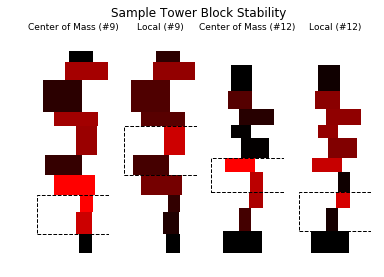

In [50]:
XR = 10
YR = 20

fig, axs = plt.subplots(1, 4)
TOWER_IDS = [9, 12]

for i, tower_id in enumerate(TOWER_IDS):
    stabs, weakest_ypos, roi_s, roi_e, pivot_xs = analyze_tower_com(TOWERS[tower_id])

    ax = axs[2*i]

    plot_tower(tower_id, block_stabilities=stabs, ax=ax, pivot_xs=None, bw=True)
    roi = patches.Rectangle((-XR, roi_s), 2*XR, roi_e-roi_s, linewidth=1, linestyle='--', color='black', fill=False)

    ax.set_xlim((-XR, XR))
    ax.set_ylim((0, YR))
    ax.add_patch(roi)
    ax.set_title("Center of Mass (#%d)" % tower_id, fontsize=9)
    ax.axis('off')

    ax = axs[2*i+1]

    block_stabs, tower_stab, weakest_local_ypos, roi_local_s, roi_local_e = analyze_tower_local(TOWERS[tower_id])
    plot_tower(tower_id, block_stabilities=block_stabs, ax=ax, bw=True)

    roi = patches.Rectangle((-XR, roi_local_s), 2*XR, roi_local_e-roi_local_s, linewidth=1, linestyle='--', color='black', fill=False)
    ax.set_xlim((-XR, XR))
    ax.set_ylim((0, YR))
    ax.add_patch(roi)
    ax.set_title("Local (#%d)" % tower_id, fontsize=9)
    ax.axis('off')
    plt.suptitle("Sample Tower Block Stability")
    plt.savefig('figures/stability_and_roi.png', dpi=300, figsize=(12, 6))

plt.show()



In [51]:

all_trials_df['correct_int'] = 0.0
all_trials_df.loc[all_trials_df['correct'] == True, 'correct_int'] = 1.0
gb = all_trials_df.groupby('tower')

tower_df = pd.DataFrame({
    'pct_correct': gb['correct_int'].mean(),
    'response_secs': gb['response_secs'].mean()
}).reset_index()
tower_df = tower_df.set_index('tower')
tower_df = tower_df.sort_values('pct_correct')

block_df = pd.DataFrame(columns=['stability_local', 'stability_com'])

# Analyze stability
for i, tower in enumerate(TOWERS):
    block_stabilities, tower_stability, weakest_local_ypos, roi_local_s, roi_local_e = analyze_tower_local(tower)
    block_com_stabilities, weakest_ypos, roi_s, roi_e, _pivots = analyze_tower_com(tower)
    most_unstable_local = min(block_stabilities)   
    most_unstable_com = min(block_com_stabilities)       
    tower_df.loc[i, 'stability'] = tower_stability
    tower_df.loc[i, 'weakest_ypos'] = weakest_ypos
    tower_df.loc[i, 'roi_s'] = roi_s
    tower_df.loc[i, 'roi_e'] = roi_e
    tower_df.loc[i, 'roi_local_s'] = roi_local_s
    tower_df.loc[i, 'roi_local_e'] = roi_local_e
    tower_df.loc[i, 'most_local_unstable_block_idx'] = np.argmin(block_stabilities)    
    tower_df.loc[i, 'most_local_unstable_block'] = most_unstable_local
    tower_df.loc[i, 'most_com_unstable_block_idx'] = np.argmin(block_com_stabilities)    
    tower_df.loc[i, 'most_com_unstable_block'] = most_unstable_com
    tower_df.loc[i, 'local_stabilities'] = ','.join([str(x) for x in block_stabilities])    
    tower_df.loc[i, 'com_stabilities'] = ','.join([str(x) for x in block_com_stabilities])
    tower_df.loc[i, 'diff_local_stability'] = 1 - abs(0.5 - most_unstable_local)
    tower_df.loc[i, 'diff_com_stability'] = 1 - abs(0.5 - most_unstable_com)    
    
    # Build block dataframe
    block_id = 0
    for stab_com, stab_local in zip(block_com_stabilities, block_stabilities):
        block_name = 'tower:%d_block:%d' % (i, block_id)
        block_df = block_df.append(pd.Series({
            'stability_com': stab_com,
            'stability_local': stab_local
        }, name=block_name))
        block_id += 1

tower_df.to_pickle('frames/tower_df.pickle')        

In [52]:
block_df['hit_pct'] = 0

# Populate gaze pcts for each block
for idx, row in all_trials_df.iterrows():
    tower_id = row.tower
    for block_id, hit_pct in enumerate(row.block_hit_pcts):
        # Add hit pct of this block and one above (if any)
        hit_pcts = [hit_pct]
        if block_id != 9:
            hit_pct_block_above = row.block_hit_pcts[block_id+1]
            hit_pcts.append(hit_pct_block_above)
        for hp in hit_pcts:
            if str(hp) != 'nan':
                block_df.loc['tower:%d_block:%d' % (tower_id, block_id), 'hit_pct'] += hp
        
block_df.to_pickle('frames/block_df.pickle')        
block_df

,stability_local,stability_com,hit_pct
tower:0_block:0,1.000000,1.000000,0.553563
tower:0_block:1,0.770634,0.791409,0.386154
tower:0_block:2,0.390435,0.739323,0.744569
tower:0_block:3,0.528456,0.603098,1.995189
tower:0_block:4,0.848384,0.920138,1.850922
tower:0_block:5,0.723565,0.904554,0.893614
tower:0_block:6,0.791588,0.908901,0.664641
tower:0_block:7,0.917622,0.884904,0.407238
tower:0_block:8,0.988927,0.993424,0.186306
tower:0_block:9,0.973186,1.000000,0.000000
